<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
</center>
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://goo.gl/rvvZiR).**

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

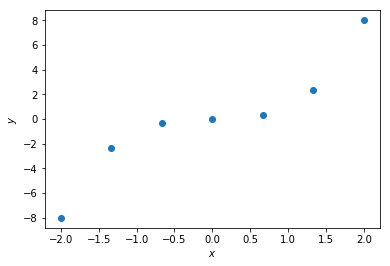

In [2]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график.

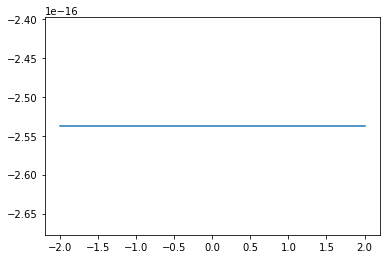

In [9]:
leaf = y.mean()
plt.plot([-2, 0, 2], [leaf] * 3)

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

left leaf: -3.555556; right leaf: 2.666667


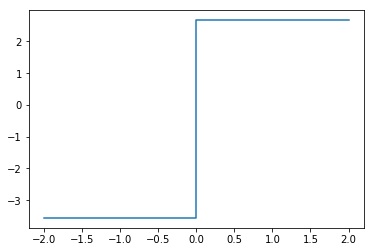

In [11]:
left_leaf = 0.0
left_leaf_counter = 0

right_leaf = 0.0
right_leaf_counter = 0

for index, x_value in enumerate(X):
    if x_value < 0.0:
        left_leaf += y[index]
        left_leaf_counter += 1
    else:
        right_leaf += y[index]
        right_leaf_counter += 1

left_leaf /= left_leaf_counter
right_leaf /= right_leaf_counter

print ("left leaf: %f; right leaf: %f" % (left_leaf, right_leaf))

plt.plot([-2.0, 0.0, 0.0, 2], [left_leaf, left_leaf, right_leaf, right_leaf])

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [36]:
def regression_var_criterion(X, y, t):
    X_variance = np.var(y)
    
    y_left = []
    y_right = []
    for index, x_value in enumerate(X):
        if x_value < t:
            y_left.append(y[index])
        else:
            y_right.append(y[index])
    
    X_l_variance = np.var(y_left)
    X_r_variance = np.var(y_right)
    
    result = X_variance - len(y_left) / len(y) * X_l_variance - len(y_right) / len(y) * X_r_variance
#     print("y left: %s" % str(y_left))
#     print("y rignt: %s" % str(y_right))
#     print("X_l variance: %f; X_r variance: %f" % (X_l_variance, X_r_variance))
#     print("Regression variance criterion: %f" % result)
    
    return result

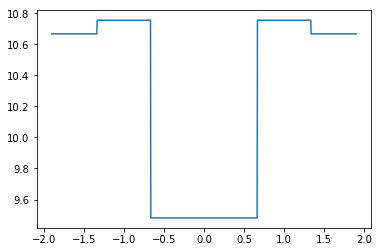

In [39]:
T = np.linspace(-1.9, 1.9, 1000)
Q = [regression_var_criterion(X, y, t) for t in T]

plt.plot(T, Q)

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- Нет

**Ответ:** нет.

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

[-2.         -1.33333333 -0.66666667  0.          0.66666667  1.33333333
  2.        ]
[-8.         -2.37037037 -0.2962963   0.          0.2962963   2.37037037
  8.        ]


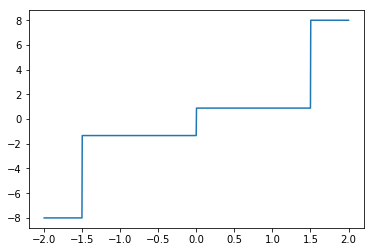

In [26]:
first_leaf = 0.0
first_leaf_counter = 0

second_leaf = 0.0
second_leaf_counter = 0

third_leaf = 0.0
third_leaf_counter = 0

fourth_leaf = 0.0
fourth_leaf_counter = 0

for index, x_value in enumerate(X):
    if x_value < 0:
        if x_value < -1.5:
            first_leaf += y[index]
            first_leaf_counter += 1
        else:
            second_leaf += y[index]
            second_leaf_counter += 1
    else:
        if x_value < 1.5:
            third_leaf += y[index]
            third_leaf_counter += 1
        else:
            fourth_leaf += y[index]
            fourth_leaf_counter += 1

first_leaf /= first_leaf_counter
second_leaf /= second_leaf_counter
third_leaf /= third_leaf_counter
fourth_leaf /= fourth_leaf_counter

def tree_func(arg):
    global first_leaf
    global second_leaf
    global third_leaf
    global fourth_leaf
    
    if arg < 0.0:
        if arg < -1.5:
            return first_leaf
        else:
            return second_leaf
    else:
        if arg < 1.5:
            return third_leaf
        else:
            return fourth_leaf

print(X)
print(y)
arguments = np.linspace(-2, 2, 1000)
plt.plot(arguments, [tree_func(arg) for arg in arguments])
        

**<font color='red'>Вопрос 2.</font> Из скольки отрезков состоит график, изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- 7
- 8

**Ответ:** 7

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [114]:
df = pd.read_csv("../1st_week/mlbootcamp5_train.csv", 
                 index_col="id", sep=";")

In [115]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах", а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`.

In [116]:
df["age_in_years"] = df["age"] / 365.25
X = pd.get_dummies(df, columns=["cholesterol", "gluc"])
X.head()

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,age_in_years,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,0,0,1,0,50.357290,1,0,0,1,0,0
1,20228,1,156,85.0,140,90,0,0,1,1,55.381246,0,0,1,1,0,0
2,18857,1,165,64.0,130,70,0,0,0,1,51.627652,0,0,1,1,0,0
3,17623,2,169,82.0,150,100,0,0,1,1,48.249144,1,0,0,1,0,0
4,17474,1,156,56.0,100,60,0,0,0,0,47.841205,1,0,0,1,0,0


Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [117]:
y = df["cardio"]
X.drop(["cardio", "age"], axis=1, inplace=True)

X_train, X_valid, y_train, y_valid = train_test_split(X.values, y, test_size=0.3, random_state=17)

print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(49000, 15) (21000, 15) (49000,) (21000,)


Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [118]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best')

In [119]:
export_graphviz(tree,
                feature_names=list(X.columns),
                out_file="task_3_tree.dot", filled=True)
!dot -Tpng task_3_tree.dot -o task_3_tree.png

<img src="task_3_tree.png" />

**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- age, ap_hi, chol=3

**Ответ:** age, ap_hi, chol=3

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [150]:
predict = tree.predict(X_valid)
accuracy = accuracy_score(y_valid, predict)
print("Accuracy: %f" % accuracy)

Accuracy: 0.721286


Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [140]:
tree_params = {'max_depth': list(range(2, 11))}

tree_2 = DecisionTreeClassifier(random_state=17)
tree_grid = GridSearchCV(tree_2, tree_params, cv=5, n_jobs=-1, verbose=True)
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   28.7s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

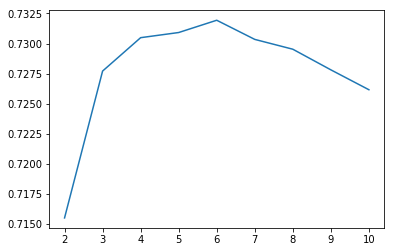

In [141]:
cv_results = pd.DataFrame(tree_grid.cv_results_)

plt.plot(cv_results["param_max_depth"], cv_results["mean_test_score"])

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [153]:
best_depth = tree_grid.best_params_["max_depth"]
best_accuracy = accuracy_score(y_valid, tree_grid.best_estimator_.predict(X_valid))

accuracy_diff = (best_accuracy - accuracy) / accuracy * 100

print("Best depth: %d; best accuracy: %f" % (best_depth, best_accuracy))
print("Accuracy diff: %f" % accuracy_diff)

tree_3 = DecisionTreeClassifier(max_depth=6, random_state=17)
tree_3.fit(X_train, y_train)

pred = tree_3.predict(X_valid)
best_accuracy_2 = accuracy_score(y_valid, pred)
print("best accuracy 2: %f" % best_accuracy_2)

Best depth: 6; best accuracy: 0.725810
Accuracy diff: 0.627187
best accuracy 2: 0.725810


**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева четкий пик, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке?**
- да, да
- да, нет
- нет, да
- нет, нет

**Ответ:** да, нет.

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках.

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- Верхнее артериальное давление от 140 до 160 (мм рт.ст.)
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [177]:
def predicate_45_50(value):
    if 45 <= value < 50:
        return 1
    return 0

def predicate_50_55(value):
    if 50 <= value < 55:
        return 1
    return 0

def predicate_55_60(value):
    if 55 <= value < 60:
        return 1
    return 0

def predicate_60_65(value):
    if 60 <= value < 65:
        return 1
    return 0

def predicate_120_140(value):
    if 120 <= value < 140:
        return 1
    return 0

def predicate_140_160(value):
    if 140 <= value < 160:
        return 1
    return 0

def predicate_160_180(value):
    if 160 <= value < 180:
        return 1
    return 0

y = df["cardio"]

X = df.copy(deep=True)
X.drop(["age", "cardio", "gluc", "height", "weight", "ap_lo", "alco", "active"],axis=1, inplace=True)
X = pd.get_dummies(X, columns=["cholesterol"])

X.rename(columns={"gender": "male"}, inplace=True)
X["male"] = X["male"].map({1: 0, 2: 1})

X["age_45_50"] = X["age_in_years"]
X["age_45_50"] = X["age_45_50"].map(predicate_45_50)

X["age_50_55"] = X["age_in_years"]
X["age_50_55"] = X["age_50_55"].map(predicate_50_55)

X["age_55_60"] = X["age_in_years"]
X["age_55_60"] = X["age_55_60"].map(predicate_55_60)

X["age_60_65"] = X["age_in_years"]
X["age_60_65"] = X["age_60_65"].map(predicate_60_65)

X.drop(["age_in_years"], axis=1, inplace=True)

X["ap_hi_120_140"] = X["ap_hi"]
X["ap_hi_120_140"] = X["ap_hi_120_140"].map(predicate_120_140)

X["ap_hi_140_160"] = X["ap_hi"]
X["ap_hi_140_160"] = X["ap_hi_140_160"].map(predicate_140_160)

X["ap_hi_160_180"] = X["ap_hi"]
X["ap_hi_160_180"] = X["ap_hi_160_180"].map(predicate_160_180)

X.drop(["ap_hi"], axis=1, inplace=True)

tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best')

In [178]:
export_graphviz(tree,
                feature_names=list(X.columns),
                out_file="task_5_tree.dot", filled=True)
!dot -Tpng task_5_tree.dot -o task_5_tree.png

<img src="task_5_tree.png" />

**Ответ:** Верхнее артериальное давление от 140 до 160 (мм рт.ст.)